# Dengue Outbreak Simulator Emulation with GP

### Import Libraries

In [95]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Specify Paths, N, Response Vars


In [96]:
train_path = 'Dengue/Data/Simulation/Duration/DD-AML-train-LHS-5000-condSim-logDuration.txt'
test_path = 'Dengue/Data/Simulation/Duration/DD-AML-test-LHS-10000-condSim-logDuration.txt'

In [97]:
number_test_points = 1000
number_train_points = 100

# ---- possible response variable options: ----

response_var = 'log duration'

#response_var = 'maxIncidence'

#response_var = 'outbreakProb'
# can't calculate from this dataset? because each row corresponds to averages from 100 simulation runs

#response_var = 'epidemicSize' 
# they did not use this in the paper, used outbreak probability
# "proportion of simulation runs in which more than 0.1% of the population becomes infected"

In [98]:
# read data
train_set = pd.read_csv(train_path, sep = "\t")
test_set = pd.read_csv(test_path, sep = "\t")

In [99]:
# take log of duration
train_set['log duration'] = np.log(train_set['duration'])  
test_set['log duration'] = np.log(test_set['duration'])

# drop unnecessary columns
drop_cols = [ 'simRound', 'simID']

possible_response_vars = ['log duration', 'duration', 'epidemicSize', 'maxIncidence','sd_maxIncidence', 'sd_epidemicSize', 'sd_duration']

for item in possible_response_vars:
    if item != response_var:
        drop_cols.append(item)

train_set = train_set.drop(drop_cols, axis=1)
test_set = test_set.drop(drop_cols, axis=1)

# select first n from train, test
Xtrain_df = train_set.drop(response_var, axis=1)[0:number_train_points]
Xtrain = Xtrain_df.to_numpy()
Ytrain_df = train_set[response_var][0:number_train_points]
Ytrain = Ytrain_df.to_numpy().reshape(-1, 1)

Xtest_df = test_set.drop(response_var, axis=1)[0:number_test_points]
Xtest = Xtest_df.to_numpy()
Ytest_df = test_set[response_var][0:number_test_points]
Ytest = Ytest_df.to_numpy().reshape(-1, 1)

In [100]:
# define function to reload the data and reset, so that I can call it each time I model.

def reset_data(numtrain = 1000, numtest = 1000, res_var=response_var, df = False): 

    # read data
    train_set = pd.read_csv(train_path, sep = "\t")
    test_set = pd.read_csv(test_path, sep = "\t")

    # take log of duration
    train_set['log duration'] = np.log(train_set['duration'])  
    test_set['log duration'] = np.log(test_set['duration'])

    # drop unnecessary columns
    drop_cols = [ 'simRound', 'simID']

    possible_response_vars = ['log duration', 'duration', 'epidemicSize', 'maxIncidence','sd_maxIncidence', 'sd_epidemicSize', 'sd_duration']

    for item in possible_response_vars:
        if item != res_var:
           drop_cols.append(item)

    train_set = train_set.drop(drop_cols, axis=1)
    test_set = test_set.drop(drop_cols, axis=1)

    # size check
    numtrain = min(numtrain, len(train_set))
    numtest = min(numtest, len(test_set))

    # select random n points
    train_subset = train_set.sample(n=numtrain, random_state=22)
    Xtrain_df = train_subset.drop(res_var, axis=1)
    Xtrain = Xtrain_df.to_numpy()
    Ytrain_df = train_subset[res_var]
    Ytrain = Ytrain_df.to_numpy().reshape(-1, 1)

    test_subset = test_set.sample(n=numtest, random_state=22)
    Xtest_df = test_subset.drop(res_var, axis=1)
    Xtest = Xtest_df.to_numpy()
    Ytest_df = test_subset[res_var]
    Ytest = Ytest_df.to_numpy().reshape(-1, 1)

    if df:
        return Xtrain_df, Xtest_df, Ytrain_df, Ytest_df
    else:
        return Xtrain, Xtest, Ytrain, Ytest

In [101]:
print("Displaying Original Training Data:")
train_set.head()

Displaying Original Training Data:


alphaRest  alphaAmp  alphaShift  infTicksCounts  avgVisitsCounts  pVisits  \
0   0.013191    0.5959      0.7999          4.0050           1.6668  0.61493   
1   0.026691    0.8901      0.1425          4.7738           4.4996  0.29885   
2   0.013959    0.7015      0.5965          5.0506           2.1236  0.52673   
3   0.012351    0.5541      0.0989          5.6122           1.2948  0.08969   
4   0.014151    0.7141      0.6015          4.2950           2.5860  0.68045   

   propSocialVisits  locPerSGCount  log duration  
0            0.9667         2.8297      0.612212  
1            0.3457         2.9893      0.283951  
2            0.1029        19.0329      0.772498  
3            0.7879        11.8813      0.663139  
4            0.4663        16.2437      0.789539

In [102]:
print("Displaying (Abbreviated) XTrain Data:")
Xtrain_df.head()

Displaying (Abbreviated) XTrain Data:


alphaRest  alphaAmp  alphaShift  infTicksCounts  avgVisitsCounts  pVisits  \
0   0.013191    0.5959      0.7999          4.0050           1.6668  0.61493   
1   0.026691    0.8901      0.1425          4.7738           4.4996  0.29885   
2   0.013959    0.7015      0.5965          5.0506           2.1236  0.52673   
3   0.012351    0.5541      0.0989          5.6122           1.2948  0.08969   
4   0.014151    0.7141      0.6015          4.2950           2.5860  0.68045   

   propSocialVisits  locPerSGCount  
0            0.9667         2.8297  
1            0.3457         2.9893  
2            0.1029        19.0329  
3            0.7879        11.8813  
4            0.4663        16.2437

Displaying Pairplot for All Original Training Data


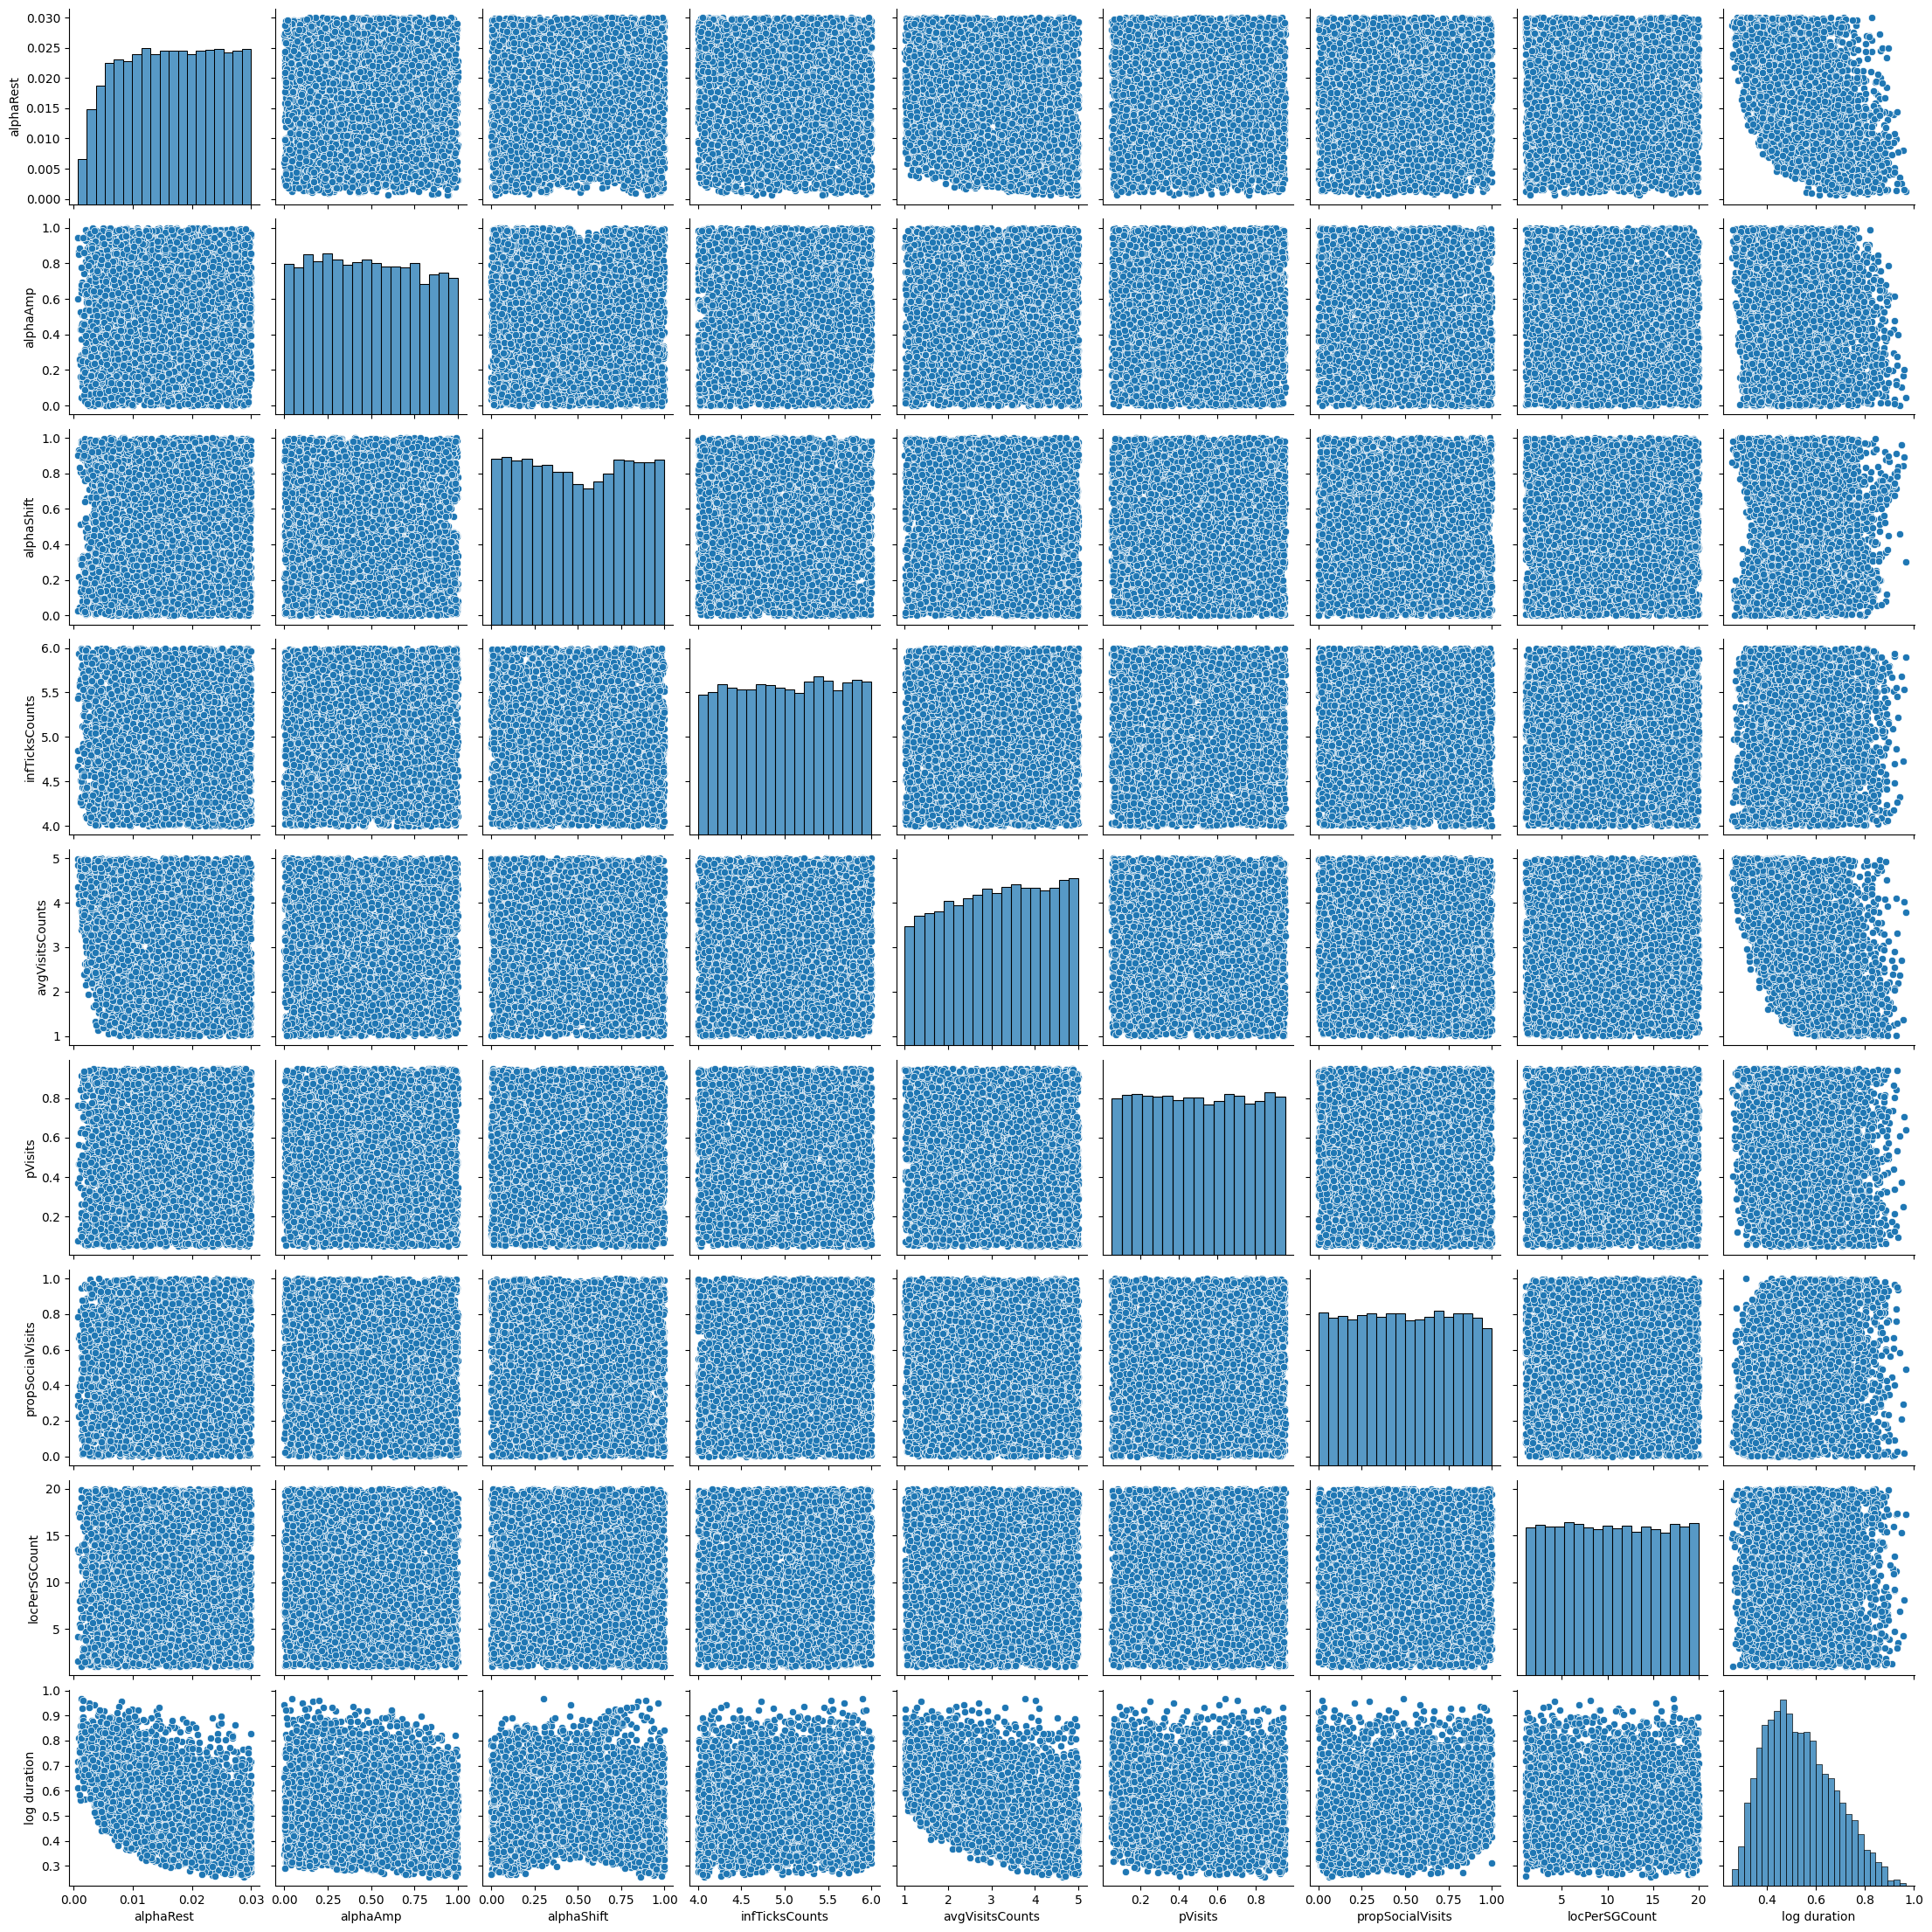

In [103]:
print("Displaying Pairplot for All Original Training Data")
sns.pairplot(train_set)

Displaying Pairplot for (Abbreviatd) Training Data


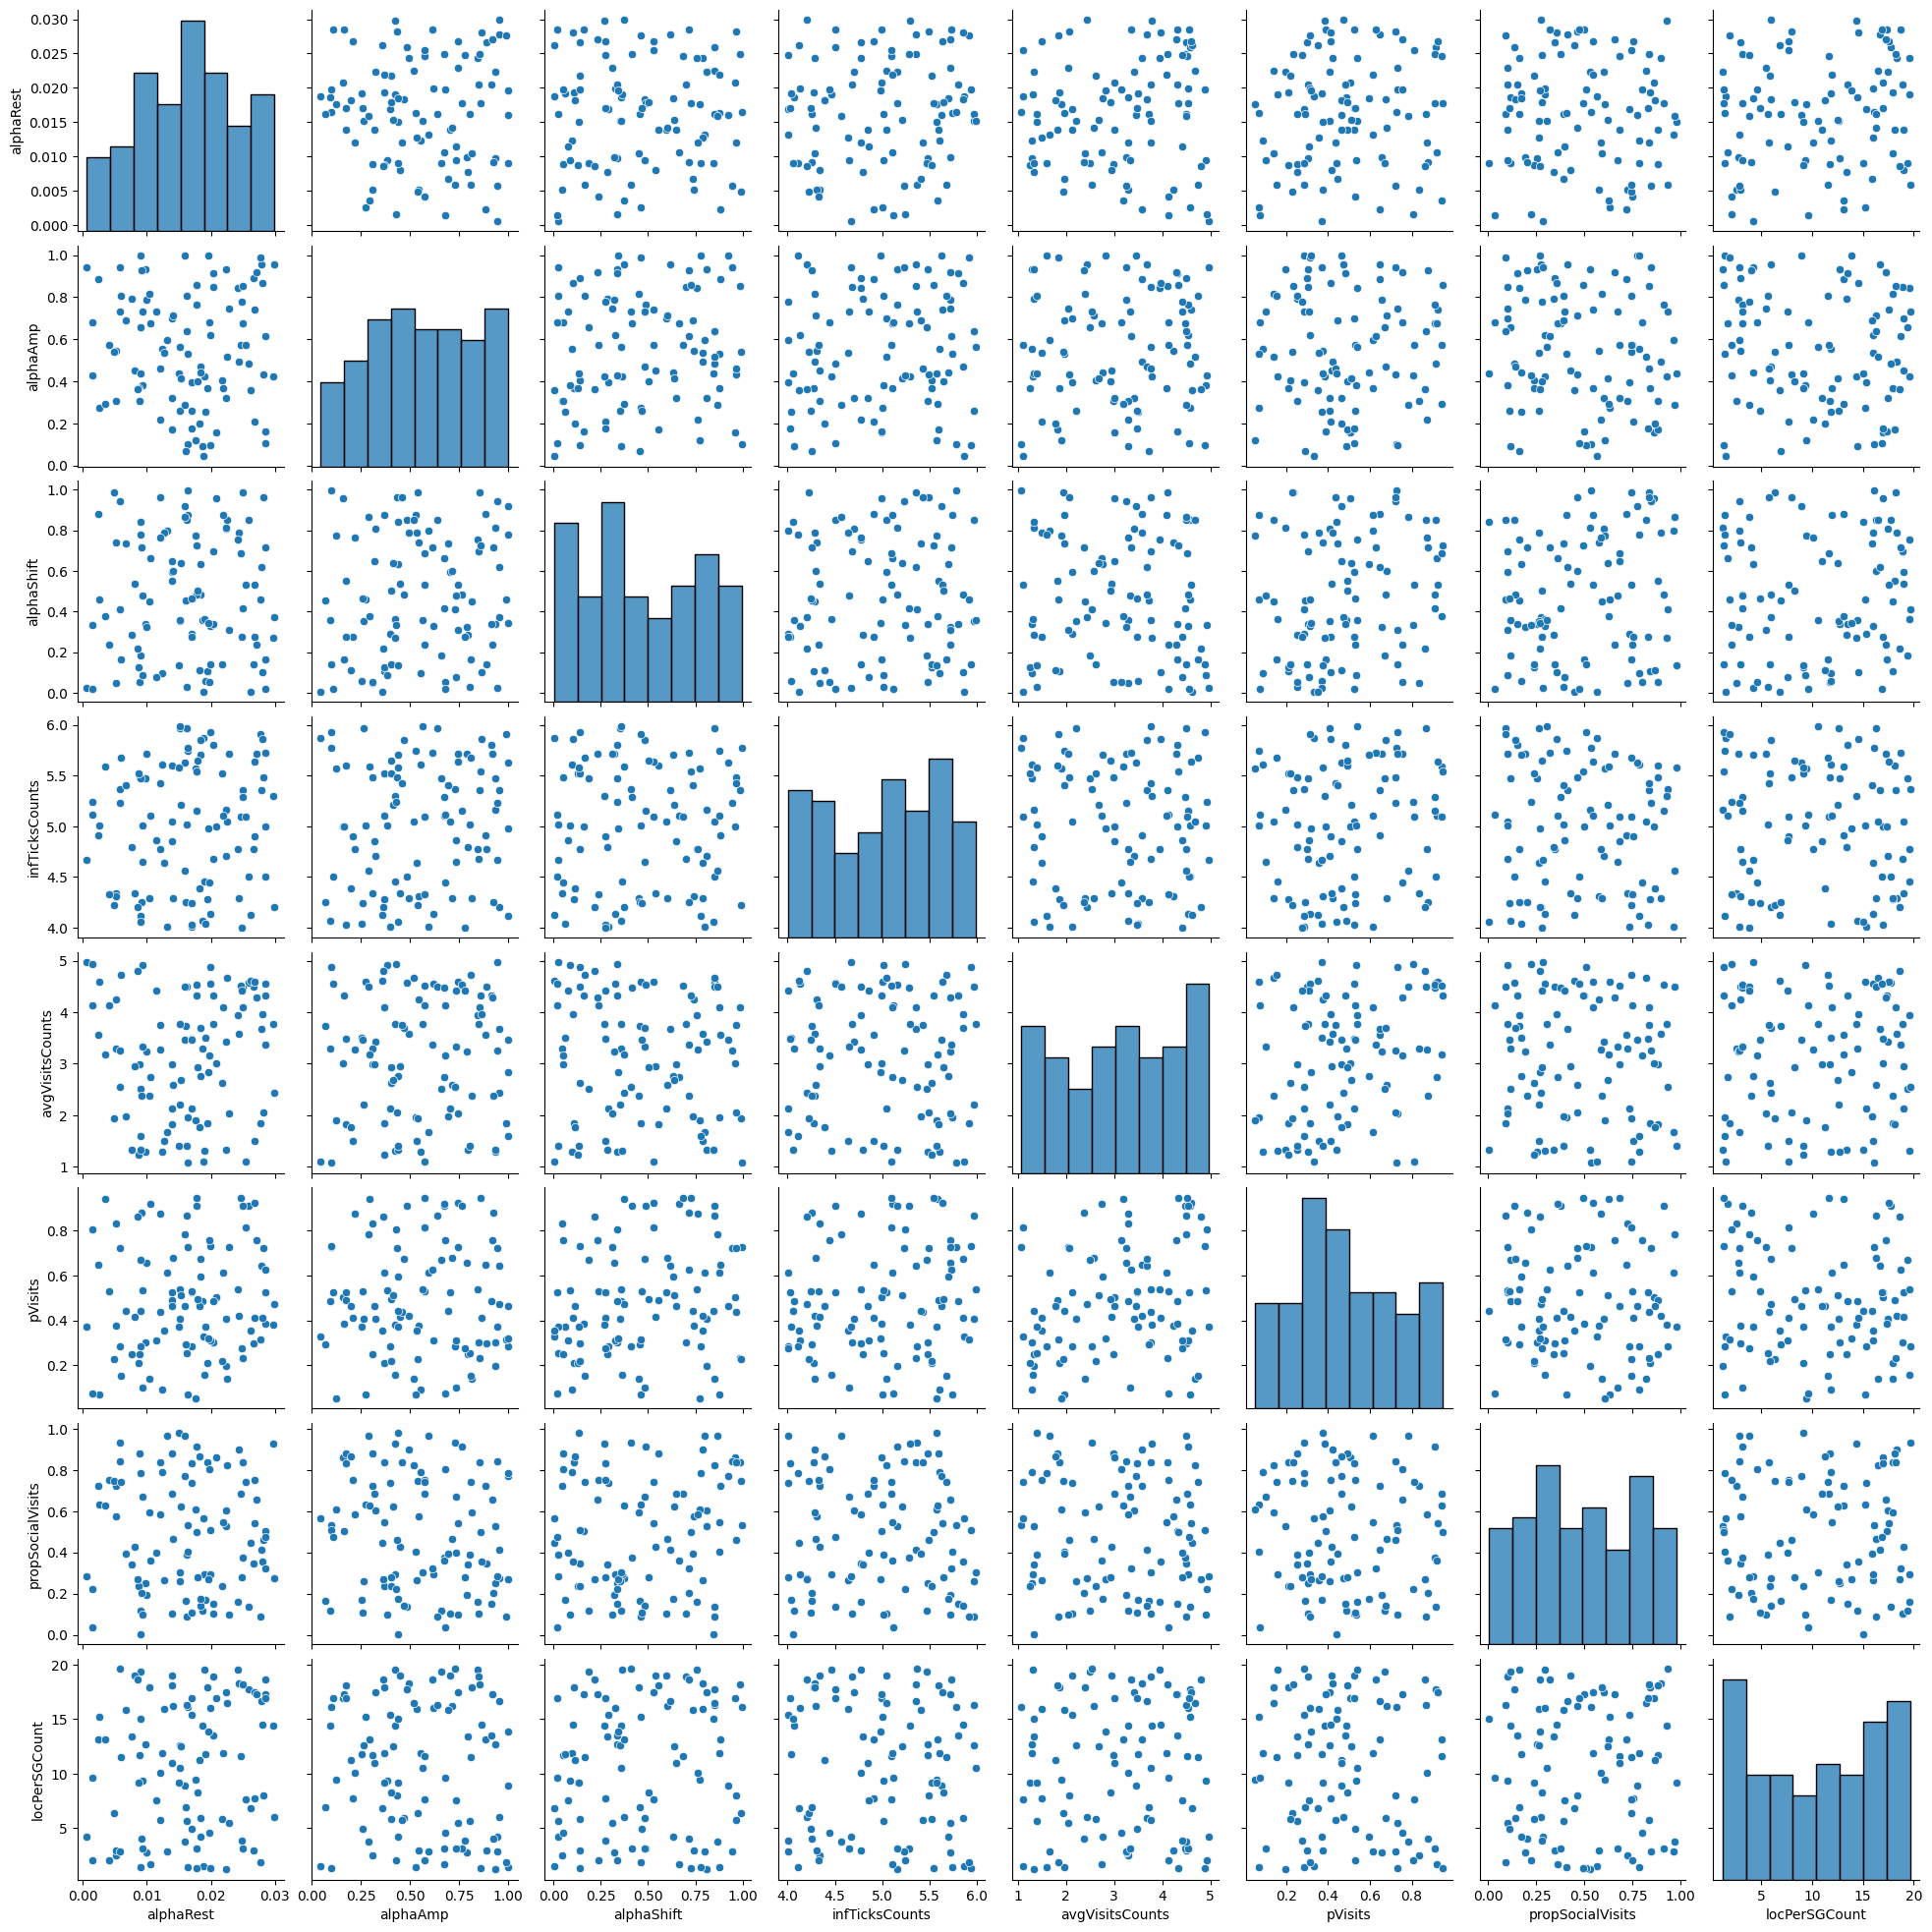

In [104]:
# to show that training set uniformly covers space
print("Displaying Pairplot for (Abbreviatd) Training Data")
sns.pairplot(Xtrain_df)

## Modeling

### Baseline: Multiple Linear Regression

In [105]:
Xtrain, Xtest, Ytrain, Ytest = reset_data(numtrain = 1000, numtest = 1000, res_var=response_var)

In [106]:
# test a multiple linear regression model
mlr = LinearRegression()
mlr.fit(Xtrain,Ytrain)
Ypred_mlr = mlr.predict(Xtest)

print("MSE:", mean_squared_error(Ytest, Ypred_mlr))

MSE: 0.0075696709688511925


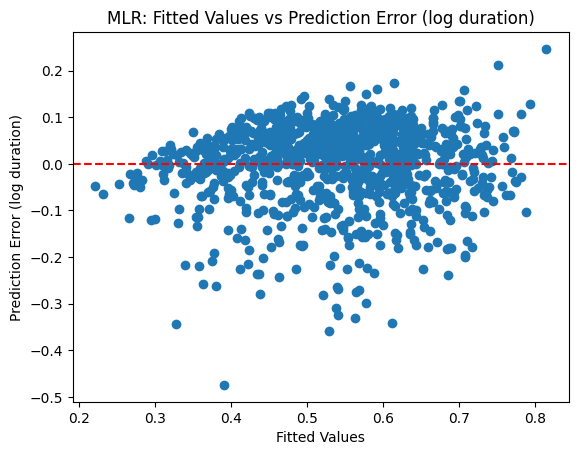

In [107]:
error_mlr = Ypred_mlr - Ytest

plt.scatter(Ypred_mlr, error_mlr)
plt.title(f"MLR: Fitted Values vs Prediction Error ({response_var})")
plt.xlabel("Fitted Values")
plt.axhline(y=0, color='red', linestyle='--')
plt.ylabel(f"Prediction Error ({response_var})")
plt.show()

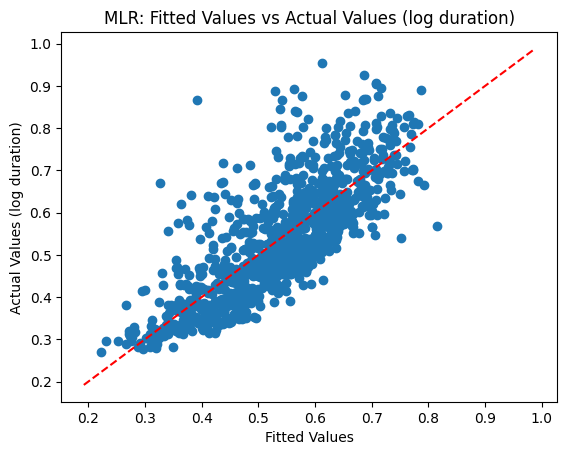

In [108]:
# Fitted Values vs Actual Values

plt.scatter(Ypred_mlr, Ytest)
plt.title(f"MLR: Fitted Values vs Actual Values ({response_var})")
plt.xlabel("Fitted Values")
plt.ylabel(f"Actual Values ({response_var})")

# to add a y = x line
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
range_max = max(x_max, y_max)
range_min = min(x_min, y_min)
plt.plot([range_min, range_max], [range_min, range_max], 'r--', label='y=x')  # 'r--' specifies a red dashed line

plt.show()

### GP: One-Dimensional Input

*Possible predictor variables*

alphaRest, alphaAmp, alphaShift, infTicksCounts, avgVisitsCounts, pVisits, propSocialVisits, locperSGCount*

In [109]:
# choose predictor variable
pred_var = 'alphaAmp'

In [110]:
Xtrain_df, Xtest_df, Ytrain_df, Ytest_df = reset_data(numtrain = 2000, numtest=100, res_var=response_var, df = True)

In [111]:
# only use one input variable
Xtrain = Xtrain_df[pred_var].to_numpy().reshape(-1, 1)
Xtest = Xtest_df[pred_var].to_numpy().reshape(-1,1)

Ytrain = Ytrain_df
Ytest = Ytest_df

# form complete training data array to help with sorting
XYtrain = np.column_stack((Xtrain, Ytrain))

In [112]:
# create model

simple_mod = gpflow.models.GPR(
    data=(XYtrain[:, 0].reshape(-1, 1), XYtrain[:, 1].reshape(-1, 1)),
    kernel=gpflow.kernels.Matern12(),  
)

# assign function variance to be ~0
simple_mod.likelihood.variance.assign(1e-5)
gpflow.set_trainable(simple_mod.likelihood.variance, False)

print("Noise variance:", simple_mod.likelihood.variance.numpy())  # Should print 1e-5


# train the model
opt = gpflow.optimizers.Scipy()
opt.minimize(simple_mod.training_loss, simple_mod.trainable_variables)

Noise variance: 1.0000000000000004e-05


  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 1172.070752786391
        x: [-6.994e+00 -8.551e-01]
      nit: 18
      jac: [-4.498e+00  3.623e-02]
     nfev: 65
     njev: 65
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [113]:
simple_mod

<gpflow.models.gpr.GPR object at 0x3a0452ec0>
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.354329    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.000917246 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │ 1e-05       │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════╛

In [114]:
f_mean, _ = simple_mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
y_mean, y_var = simple_mod.predict_y(Xtest)

## 95% confidence intervals
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

In [115]:
# add to x test
XYalltest = np.column_stack((Xtest, y_mean, y_lower, y_upper, y_var, f_mean))

# sorting by X column 
XYtrain_sorted = XYtrain[XYtrain[:,0].argsort()] # sort on xs
XYalltest_sorted = XYalltest[XYalltest[:,0].argsort()] # sort on x test

In [116]:
# now separate for ease of plotting

# for training data
Xtrain = XYtrain_sorted[:,0]
Ytrain = XYtrain_sorted[:,1]

# for X test and predictions
Xtest = XYalltest_sorted[:,0]
Ytest = XYalltest_sorted[:,1]
y_lower = XYalltest_sorted[:,2]
y_upper = XYalltest_sorted[:,3]
y_var = XYalltest_sorted[:,4]
f_mean = XYalltest_sorted[:,5]

# set boundary at 0?
#y_lower = np.maximum(y_lower, 0)

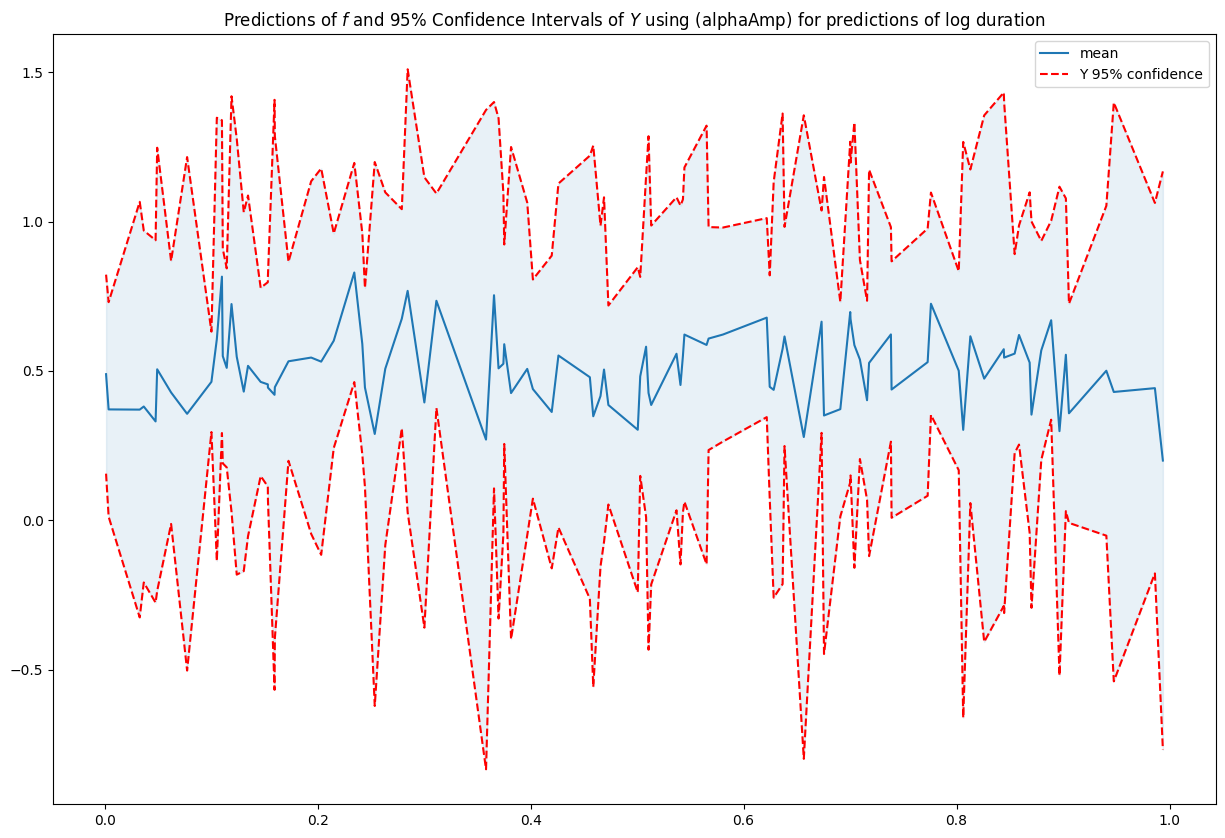

In [117]:
plt.figure(figsize=(15, 10))
#plt.plot(Xtrain, Ytrain, "kx", mew=2, label="input data")

plt.plot(Xtest, f_mean, "-", color="C0", label="mean")

plt.plot(Xtest, y_lower, "--", color="red", label="Y 95% confidence")
plt.plot(Xtest, y_upper, "--", color="red")
plt.fill_between(
    Xtest, y_lower, y_upper, color="C0", alpha=0.1)

plt.legend()
plt.title(f"Predictions of $f$ and 95% Confidence Intervals of $Y$ using ({pred_var}) for predictions of {response_var}")
plt.show()

### GP: N-Dimensional Input

In [118]:
Xtrain, Xtest, Ytrain, Ytest = reset_data(numtrain = 1000, numtest = 1000, res_var=response_var)

In [119]:
# GP: 
# takes ~40s with 2000

# create model: use matern kernel with smoothness parameter = 1/2
mod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12(),) 

# assign function variance to be ~ 0
mod.likelihood.variance.assign(1e-5)
gpflow.set_trainable(mod.likelihood.variance, False)

print("Noise variance:", simple_mod.likelihood.variance.numpy())  # Should print 1e-5

# train the model
opt = gpflow.optimizers.Scipy()
opt.minimize(mod.training_loss, mod.trainable_variables)

Noise variance: 1.0000000000000004e-05


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -601.3876954631205
        x: [ 2.173e+01 -4.804e-01]
      nit: 36
      jac: [-1.705e-06  6.251e-06]
     nfev: 53
     njev: 53
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [120]:
f_mean, _ = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
y_mean, y_var = mod.predict_y(Xtest)

## 95% confidence intervals for y
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

##### Plotting GP

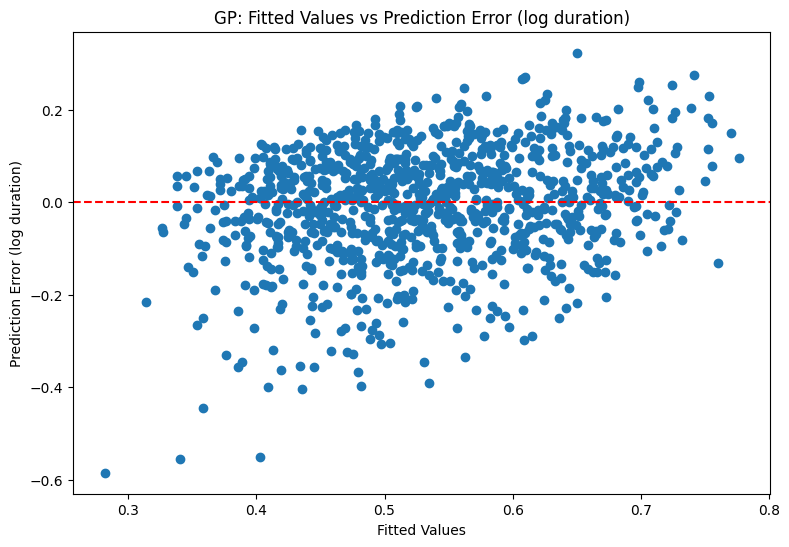

MSE: 0.015351118202068874
RMSE: 0.12389962954774673
nRMSE: 0.23304193170954798
Mean: 0.5316623864162315


In [121]:
# Fitted Values vs Prediction Error (standardized duration)
error = y_mean - Ytest

plt.figure(figsize=(9, 6))
plt.scatter(y_mean, error)
plt.title(f"GP: Fitted Values vs Prediction Error ({response_var})")
plt.xlabel("Fitted Values")
plt.ylabel(f"Prediction Error ({response_var})")

plt.axhline(y=0, color='red', linestyle='--')

plt.show()

mse = mean_squared_error(Ytest, y_mean)
rmse = mean_squared_error(Ytest, y_mean, squared=False)
nrmse = rmse / np.mean(y_mean)

print("MSE:", mse)
print("RMSE:", rmse)
print("nRMSE:", nrmse)
print("Mean:", np.mean(y_mean))


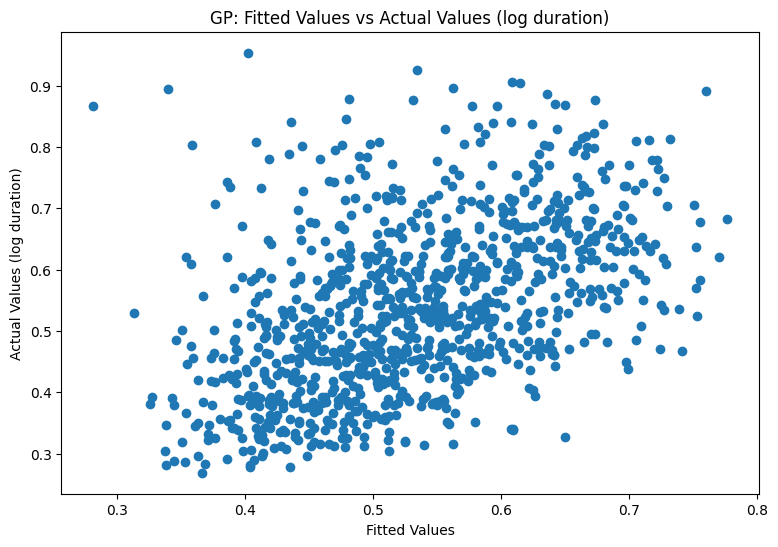

In [122]:
# Fitted Values vs Actual Values
plt.figure(figsize=(9, 6))
plt.scatter(y_mean, Ytest)
plt.title(f"GP: Fitted Values vs Actual Values ({response_var})")
plt.xlabel("Fitted Values")
plt.ylabel(f"Actual Values ({response_var})")

# to add a y = x line
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
range_max = max(x_max, y_max)
range_min = min(x_min, y_min)
#plt.plot([range_min, range_max], [range_min, range_max], 'r--', label='y=x')  # 'r--' specifies a red dashed line

plt.show()

## Modeling N-dimensional GP Results for 3 Outputs

### Functions

In [123]:
def make_ND_gp(res_var, numtrain, numtest):
    
    # reset data
    Xtrain, Xtest, Ytrain, Ytest = reset_data(numtrain, numtest, res_var)

    # create model
    mod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.Matern12(),) 

    # set variance to 0
    mod.likelihood.variance.assign(1e-5)
    gpflow.set_trainable(mod.likelihood.variance, False)

    # train model
    opt = gpflow.optimizers.Scipy()
    opt.minimize(mod.training_loss, mod.trainable_variables)

    return mod, Xtest, Ytest

In [124]:
def plot_ND_gp(model, res_var, Xtest, Ytest):
    
    mod = model

    # make predictions
    f_mean, _ = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
    y_mean, y_var = mod.predict_y(Xtest)

    ## 95% confidence intervals for y
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    #print("MSE ({res_var}):", mean_squared_error(Ytest, y_mean))
    #print("RMSE ({res_var}):", mean_squared_error(Ytest, y_mean, squared=False))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

    error = y_mean - Ytest

    axes[0].scatter(y_mean, error)
    axes[0].set_title(f"GP: Fitted Values vs Prediction Error ({res_var})")
    axes[0].set_xlabel("Fitted Values")
    axes[0].set_ylabel(f"Prediction Error ({res_var})")
    axes[0].axhline(y=0, color='red', linestyle='--')

    axes[1].scatter(y_mean, Ytest)
    axes[1].set_title(f"GP: Fitted Values vs Actual Values ({res_var})")
    axes[1].set_xlabel("Fitted Values")
    axes[1].set_ylabel(f"Actual Values ({res_var})")

    # to add a y = x line
    x_min, x_max = axes[1].get_xlim()
    y_min, y_max = axes[1].get_ylim()
    range_max = max(x_max, y_max)
    range_min = min(x_min, y_min)
    plt.plot([range_min, range_max], [range_min, range_max], 'r--', label='y=x')  # 'r--' specifies a red dashed line
    
    plt.tight_layout()
    plt.show()

In [125]:
def add_stats(df, model, res_var, Xtest, Ytest, numtrain, numtest):

    mod = model

    # make predictions
    f_mean, _ = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
    y_mean, y_var = mod.predict_y(Xtest)

    mse = mean_squared_error(Ytest, y_mean)
    rmse = mean_squared_error(Ytest, y_mean, squared=False)
    nrmse = rmse / np.mean(Ytest)
    
    new_row = pd.DataFrame([{
        'Response Variable': str(res_var), 
        'N train': int(numtrain),
        'N test': int(numtest),
        'MSE': float(mse), 
        'RMSE': float(rmse), 
        'Normalized RMSE': float(nrmse)

    }])
    
    df = pd.concat([df, new_row], ignore_index=True)

    return df

In [126]:
# initialize empty dataframe

results = pd.DataFrame({
    'Response Variable': pd.Series(dtype='str'),
    'N train': pd.Series(dtype='int'),
    'N test': pd.Series(dtype='int'),
    'MSE': pd.Series(dtype='float'),
    'RMSE': pd.Series(dtype='float'),
    'Normalized RMSE': pd.Series(dtype='float')
})

### Implementation

In [127]:
# clear data from results
results = results.iloc[0:0]

In [128]:
logdur_gp, logdur_Xtest, logdur_Ytest = make_ND_gp('log duration', 2000, 2000)
epsize_gp, epsize_Xtest, epsize_Ytest = make_ND_gp('epidemicSize', 2000, 2000)
maxinc_gp, maxinc_Xtest, maxinc_Ytest = make_ND_gp('maxIncidence', 2000, 2000)

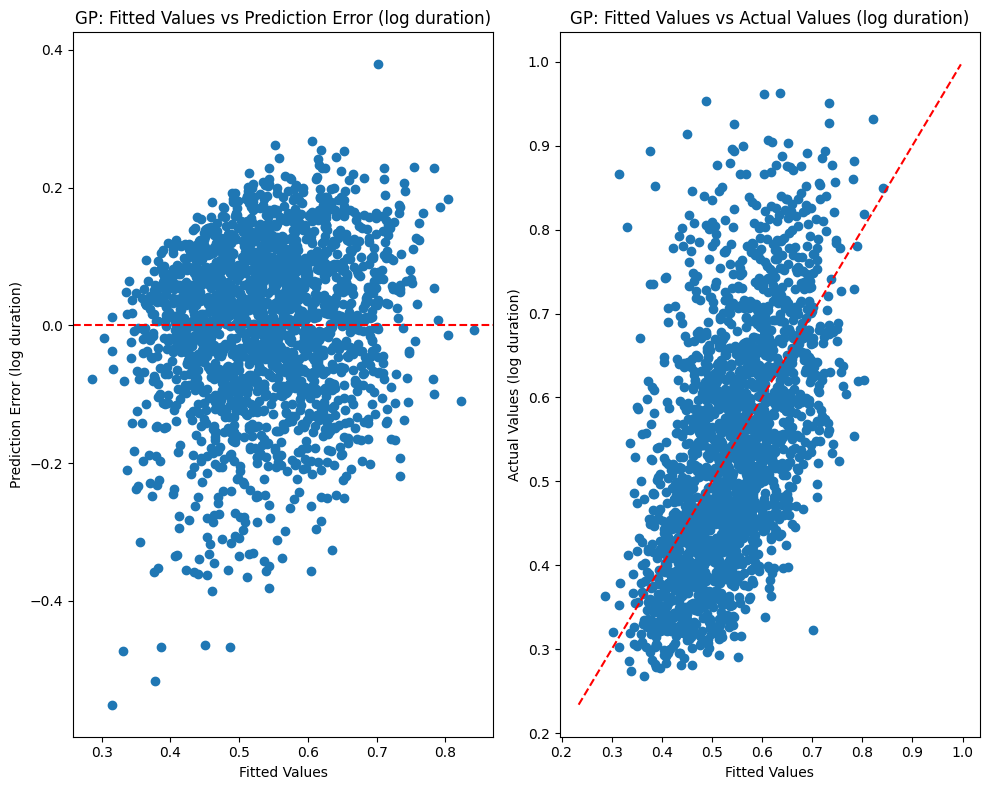

Response Variable  N train  N test       MSE      RMSE  Normalized RMSE
0      log duration     2000    2000  0.014135  0.118892         0.222219

In [129]:
plot_ND_gp(model = logdur_gp, res_var='log duration', Xtest = logdur_Xtest, Ytest = logdur_Ytest)
results = add_stats(df=results, model = logdur_gp, res_var = 'log duration', Xtest = logdur_Xtest, Ytest = logdur_Ytest, numtrain = 2000, numtest = 2000)
results

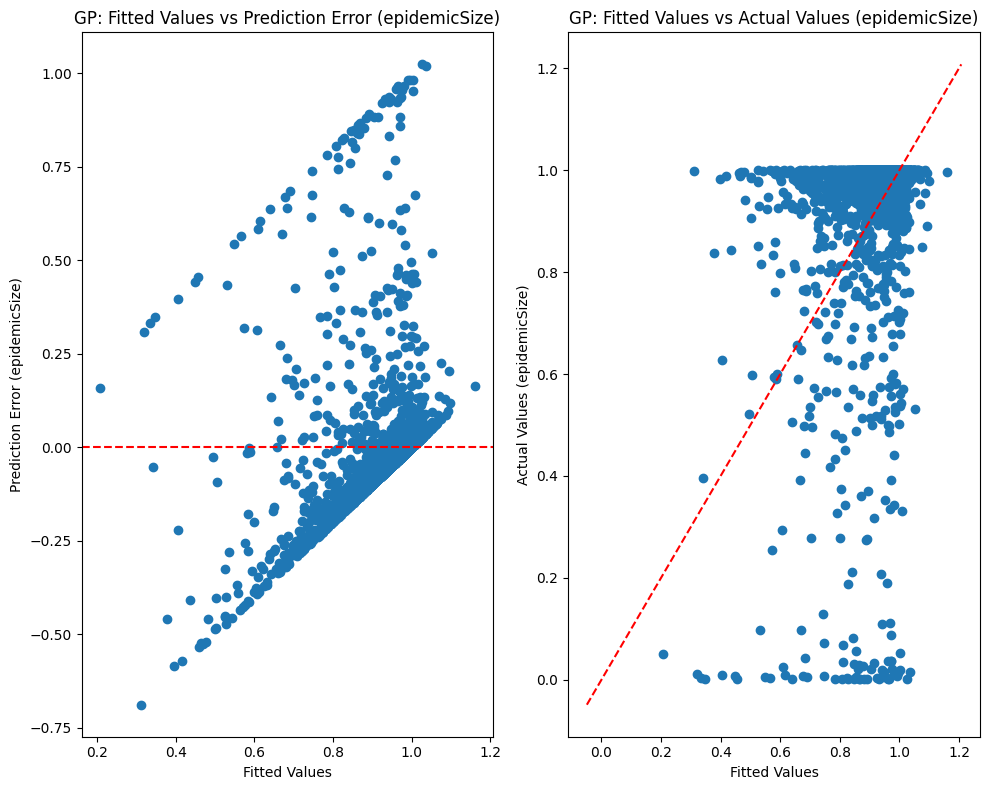

Response Variable  N train  N test       MSE      RMSE  Normalized RMSE
0      log duration     2000    2000  0.014135  0.118892         0.222219
1      epidemicSize     2000    2000  0.038711  0.196751         0.213964

In [130]:
plot_ND_gp(model = epsize_gp, res_var='epidemicSize', Xtest = epsize_Xtest, Ytest = epsize_Ytest)
results = add_stats(df=results, model = epsize_gp, res_var = 'epidemicSize', Xtest = epsize_Xtest, Ytest = epsize_Ytest, numtrain = 2000, numtest = 2000)
results

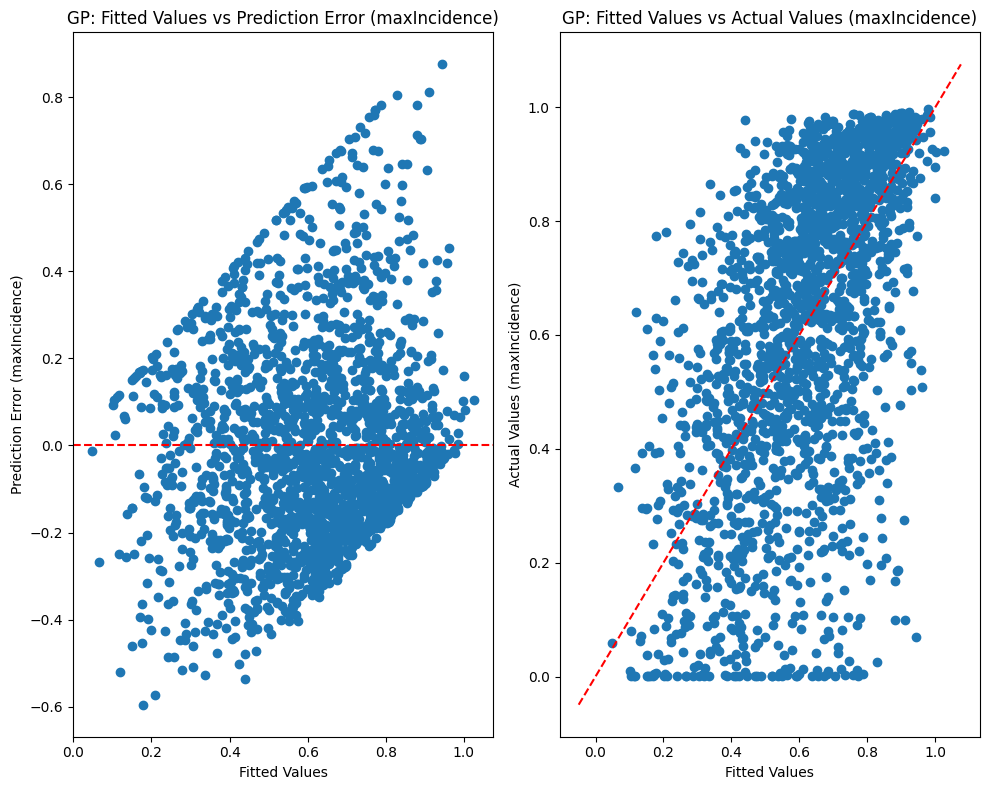

Response Variable  N train  N test       MSE      RMSE  Normalized RMSE
0      log duration     2000    2000  0.014135  0.118892         0.222219
1      epidemicSize     2000    2000  0.038711  0.196751         0.213964
2      maxIncidence     2000    2000  0.053540  0.231388         0.374167

In [131]:
plot_ND_gp(model = maxinc_gp, res_var='maxIncidence', Xtest = maxinc_Xtest, Ytest = maxinc_Ytest)
results = add_stats(df=results, model = maxinc_gp, res_var = 'maxIncidence', Xtest = maxinc_Xtest, Ytest = maxinc_Ytest, numtrain = 2000, numtest = 2000)
results

In [ ]:
results = results.iloc[0:0] # clear 
n_list = [100, 500, 1000, 2000, 5000]

for n in n_list: # takes around 30 mins to run
    
    logdur_gp, logdur_Xtest, logdur_Ytest = make_ND_gp('log duration', numtrain = n, numtest = 1000)
    results = add_stats(df=results, model = logdur_gp, res_var = 'log duration', Xtest = logdur_Xtest, Ytest = logdur_Ytest, numtrain = n, numtest = 1000)

    epsize_gp, epsize_Xtest, epsize_Ytest = make_ND_gp('epidemicSize', numtrain = n, numtest = 1000)
    results = add_stats(df=results, model = epsize_gp, res_var = 'epidemicSize', Xtest = epsize_Xtest, Ytest = epsize_Ytest, numtrain = n, numtest = 1000)

    maxinc_gp, maxinc_Xtest, maxinc_Ytest = make_ND_gp('maxIncidence', numtrain = n, numtest = 1000)
    results = add_stats(df=results, model = maxinc_gp, res_var = 'maxIncidence', Xtest = maxinc_Xtest, Ytest = maxinc_Ytest, numtrain = n, numtest = 1000)

results

In [ ]:
results.sort_values('Response Variable')

## 